In [2]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

In [18]:
def extract_features(target):
    try:
        search = lk.search_lightcurve(target, mission='TESS', author='SPOC')
        if len(search) == 0:
            print(f"No data for {target}")
            return None

        lc = search[0].download()
        lc = lc.remove_nans().remove_outliers().normalize()
        flat_lc = lc.flatten(window_length=401)

        periodogram = flat_lc.to_periodogram(method='bls')

        best_period = periodogram.period_at_max_power.value
        duration = periodogram.duration_at_max_power.value
        transit_time = periodogram.transit_time_at_max_power
        if np.isnan(best_period) or best_period<=0:
            print("No valid period found")
            return None
        folded = flat_lc.fold(period=best_period, epoch_time=transit_time)
        flux = folded.flux.value

        depth = 1 - np.min(flux)
        snr = depth / np.std(flux)
        if snr<3 and depth<0.01:
            return None
        return [best_period, depth, duration, snr]

    except:
        print(f"Skipping {target}")
        return None
    


In [27]:
search = lk.search_lightcurve(mission="TESS", author="SPOC")
all_targets = list(set(search.table['target_name']))

print("Available stars:", len(all_targets))

planet_targets = ["TOI 700", "TOI 270", "TOI 561", "TOI 1338"]

non_planet_targets = [
    "TIC 25155310",
    "TIC 19845633",
    "TIC 402980664",
    "TIC 165159410",
    "TIC 307210830",
    "TIC 261136679",
    "TIC 32869782",
    "TIC 219854185",
    "TIC 279741377",
    "TIC 14884935"
]


X, y = [], []

for star in planet_targets:
    feat = extract_features(star)
    if feat:
        X.append(feat)
        y.append(1)

for star in non_planet_targets:
    feat = extract_features(star)
    if feat:
        X.append(feat)
        y.append(0)

print("Dataset size:", len(X))




TypeError: search_lightcurve() missing 1 required positional argument: 'target'

In [5]:
len(X), len(y)

(6, 6)

In [6]:
import pandas as pd

df = pd.DataFrame(X, columns=["Period","Depth","Duration","SNR"])
df["Label"] = y
df.to_csv("exo_dataset.csv", index=False)
df.head()


,Period,Depth,Duration,SNR,Label
0,0.332239,0.006232118461980907,0.33,3.7828018923616433,1
1,0.334217,0.005823216608585979,0.33,4.496476986088838,1
2,0.335774,0.0033969902052251033,0.33,4.234139554110873,1
3,0.338170,0.011530349819097618,0.33,5.290597562404966,1
4,3.291263,0.007463530568574295,0.15,5.328788431685908,0


In [14]:
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv("exo_dataset.csv")

X = df[["Period","Depth","Duration","SNR"]]
y = df["Label"]

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X, y)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [17]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=2)
print("Cross-validation accuracy:", scores.mean())


Cross-validation accuracy: 0.6666666666666666


In [ ]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
features = X.columns

plt.bar(features, importances)
plt.title("Feature Importance")
plt.ylabel("Importance")
plt.show()


accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



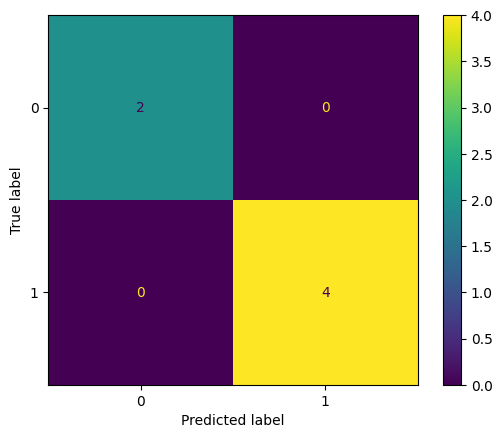

In [31]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,accuracy_score

pred = model.predict(X)
print("accuracy:",accuracy_score(y,pred))
print(classification_report(y, pred))
ConfusionMatrixDisplay.from_estimator(model, X, y)
plt.show()


In [28]:
def predict_star(target):
    features = extract_features(target)
    
    if features:
        prob = model.predict_proba([features])[0][1]
        pred = model.predict([features])[0]
        
        if pred == 1:
            print("planet robability:",prob)
        else:
            print("not planet probability:", prob)
    else:
        print("Could not analyze star.")


In [29]:
predict_star("TOI 700")
predict_star("TIC 123456789")


planet robability: 0.985
No data for TIC 123456789
Could not analyze star.


/Users/Dhruv/Desktop/expoplanet_detection/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/Dhruv/Desktop/expoplanet_detection/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
s = lk.search_lightcurve('KIC 3733346', author='Kepler', quarter=2)
lc=s.download()

In [ ]:
a =lc.plot()
# plt.savefig("lc.png")
a
